# Import Modules

In [0]:
import matplotlib.pyplot as plt
# from PIL import Image
import cv2
import pandas as pd
import numpy as np
import os
from numpy import asarray

%tensorflow_version 1.x
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, BatchNormalization, Reshape, MaxPooling2D, CuDNNLSTM, Embedding
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, f1_score, recall_score, hamming_loss, zero_one_loss

# from keras.preprocessing.image import ImageDataGenerator
# from keras.models import Sequential
# from keras.layers import Conv2D
# from keras.layers import MaxPooling2D
# from keras.layers import Dense
# from keras.layers import Flatten

# Data Preparation

In [6]:
cd "/content/drive/My Drive/SemEval_2020/memotion_analysis_training_data"

/content/drive/My Drive/SemEval_2020/memotion_analysis_training_data


## Read CSV Data

In [7]:
PATH_CSV = "data_7000_new.csv"
PATH_IMG = "./data_7000/"
trainX=[]
data = pd.read_csv(PATH_CSV,usecols=[0,3,8]) # header=None 
data.columns = ['Image_name', 'OCR_extracted_text', 'Overall_Sentiment']
data.shape

(6600, 3)

In [8]:
data['Overall_Sentiment'].value_counts()

positive                                                          2912
neutral                                                           2073
very_positive                                                      957
negative                                                           439
very_negative                                                      138
positivechandler_Friday-Mood-AF.-meme-Friends-ChandlerBing.jpg       1
Name: Overall_Sentiment, dtype: int64

In [9]:
# replace wrong data
data.replace('positivechandler_Friday-Mood-AF.-meme-Friends-ChandlerBing.jpg', 'positive',inplace=True)
#or delete wrong data
# data = data[data['Overall_Sentiment'].isin(['positive','neutral','very_positive','negative','very_negative'])]
data['Overall_Sentiment'].value_counts()

positive         2913
neutral          2073
very_positive     957
negative          439
very_negative     138
Name: Overall_Sentiment, dtype: int64

## Read Image data

In [0]:
from tqdm import tqdm

In [0]:
# #use pillow, use the same data for missing channels in error image

# size = 73, 50
# X = [ ]     # creating an empty array
# error = []
# for img_name in tqdm(data['Image_name']):
#   if(os.path.isfile(PATH_IMG + img_name)):
#     image = Image.open(PATH_IMG + img_name)
#     img = asarray(image.resize(size))
#     if img.ndim != 3:
#       img = np.dstack([img, img, img])
#       error.append(img_name)
#     X.append(img)  # storing each image in array X
#   else:
#     error.append(img_name)
# X = np.array(X)    # converting list to array
# print(error)

In [0]:
## use cv2, and delete 2 channels error image
c = 0
size = 73,50  # img size: height, width 
X = [ ]     # creating an empty array
error = []
for img_name in data['Image_name']:
  c += 1
#   image = Image.open(PATH_IMG + img_name)
#   img = asarray(image.resize(size))
  if(os.path.isfile(PATH_IMG + img_name)):
    image = cv2.imread((PATH_IMG + img_name), cv2.IMREAD_COLOR)
    if image is not None:
#       pass
      img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
      img = cv2.resize(img, size)
      if img.ndim != 3:                  # if the image is not RGB
        img = np.dstack([img, img, img]) # use the same value for the 3 RGB channels
      X.append(img)  # storing each image in array X
    else:
      print('None:{}'.format(img_name))
      error.append(img_name)
  else:
    print('Not Exists:{}'.format(img_name))
    error.append(img_name)
  print(c,img.shape, img_name)
print(error)

X = np.array(X)   # converting list to array

In [0]:
data = data[~data['Image_name'].isin(error)] # delete data of error images

Y = data['Overall_Sentiment']
num_class = 5
Y = to_categorical(Y.factorize()[0])

width, height, channels = X.shape[1:]

## *Or Import processed data*

In [0]:
# Import pre-processed image data
import pickle 

# pickle_out = open("/content/drive/My Drive/SemEval_2020/trainY.pickle", "wb")
# pickle.dump(Y, pickle_out)
# pickle_out.close()

data = pickle.load(open("/content/drive/My Drive/SemEval_2020/pickles/data_processed.pickle", "rb"))
error = pickle.load(open("/content/drive/My Drive/SemEval_2020/pickles/error_26img_name.pickle", "rb"))
X = pickle.load(open("/content/drive/My Drive/SemEval_2020/pickles/X_6574_73-50.pickle", "rb"))
Y = pickle.load(open("/content/drive/My Drive/SemEval_2020/pickles/Y_6574.pickle", "rb"))
width, height, channels = X.shape[1:]

In [32]:
data.shape,len(error),X.shape,Y.shape

((6574, 3), 26, (6574, 50, 73, 3), (6574, 5))

# Modelling

## Text Data + LSTM

In [0]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

In [10]:
t = Tokenizer()
X_text = data['OCR_extracted_text']
X_text = [str(i) for i in X_text]
t.fit_on_texts(X_text)
vocab_size = len(t.word_index) + 1
print (vocab_size)

12882


In [11]:
data['OCR_extracted_text']

0       The best of #10 YearChallenge! Completed in le...
1       Sam Thorne @Strippin ( Follow Follow Saw every...
2                  10 Year Challenge - Sweet Dee Edition 
3       10 YEAR CHALLENGE WITH NO FILTER 47 Hilarious ...
4       1998: "Don't get in car with strangers" 2008: ...
                              ...                        
6595    Tuesday is Mardi Gras Wednesday is Valentine's...
6596    MUST WATCH MOVIES OF 2017 ITI Chennai memes MA...
6597    LESS MORE TALKING PLANNING SODA JUNK FOOD COMP...
6598    When I have time is a fantasy. no one has time...
6599    The starting point for every good idea is "Wha...
Name: OCR_extracted_text, Length: 6600, dtype: object

In [12]:
encoded_train = t.texts_to_sequences(X_text)
max(list(map(lambda x: len(x), encoded_train)))

192

In [13]:
max_length = 192
padded_train = pad_sequences(encoded_train, maxlen=max_length, padding='post')

padded_train[1]

array([3521, 5297, 5298,  209,  209,  565,  155,  797,  233, 1006,  444,
        527,  544,   40,  693,  755,  403, 1078,  289,  385, 1433,  527,
        266, 3522, 1007,  121, 5299,  302, 5300, 3522,  121, 3523,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,   

In [14]:
Y = data['Overall_Sentiment'] # it uses the full 6600 data set instead the processed 6574 data set
num_class = 5
Y = to_categorical(Y.factorize()[0])
padded_train.shape, Y.shape

((6600, 192), (6600, 5))

Split data into 80% training set and 20% test set using stratified sampling

In [23]:
# Train-test Split
np.random.RandomState(0)
trainX, testX, trainY, testY = train_test_split(padded_train, Y, test_size=0.2, random_state=0,stratify=Y)
# summarize dataset shape
print('Train', trainX.shape, trainY.shape)
print('Test', (testX.shape, testY.shape))

# summarize pixel values
print('Train', trainX.min(), trainX.max(), trainX.mean(), trainX.std())
print('Test', testX.min(), testX.max(), testX.mean(), testX.std())

Train (5280, 192) (5280, 5)
Test ((1320, 192), (1320, 5))
Train 0 12881 97.01054194286615 784.8975767223017
Test 0 12850 96.29437736742425 791.9254459488213


In [25]:
model = Sequential()
model.add(Embedding(vocab_size, 100, input_length=max_length))
model.add(Dropout(0.1))


model.add(CuDNNLSTM(128, return_sequences=True))
model.add(Dropout(0.1))
model.add(Flatten())
model.add(Dense(32, activation='relu'))

model.add(Dense(5, activation='softmax'))

# opt = tf.keras.optimizers.Adam(lr=1e-3, decay=1e-6)
model.compile(loss = "categorical_crossentropy",  #sparse_categorical_crossentropy
             optimizer = 'adam',
             metrics = ['accuracy'])
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 192, 100)          1288200   
_________________________________________________________________
dropout_6 (Dropout)          (None, 192, 100)          0         
_________________________________________________________________
cu_dnnlstm_3 (CuDNNLSTM)     (None, 192, 128)          117760    
_________________________________________________________________
dropout_7 (Dropout)          (None, 192, 128)          0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 24576)             0         
_________________________________________________________________
dense_6 (Dense)              (None, 32)                786464    
_________________________________________________________________
dense_7 (Dense)              (None, 5)                

In [26]:
results = model.fit(trainX, trainY, epochs=50, shuffle=True, validation_data=(testX,testY), batch_size=64)

Train on 5280 samples, validate on 1320 samples
Epoch 1/50
5280/5280 [==============================] - 2s 302us/sample - loss: 1.3119 - acc: 0.4322 - val_loss: 1.3032 - val_acc: 0.4409
Epoch 2/50
5280/5280 [==============================] - 1s 227us/sample - loss: 1.2396 - acc: 0.4475 - val_loss: 1.3337 - val_acc: 0.4114
Epoch 3/50
5280/5280 [==============================] - 1s 228us/sample - loss: 0.9580 - acc: 0.5915 - val_loss: 1.5516 - val_acc: 0.3318
Epoch 4/50
5280/5280 [==============================] - 1s 233us/sample - loss: 0.6361 - acc: 0.7576 - val_loss: 1.9947 - val_acc: 0.3424
Epoch 5/50
5280/5280 [==============================] - 1s 228us/sample - loss: 0.4187 - acc: 0.8396 - val_loss: 2.8730 - val_acc: 0.3417
Epoch 6/50
5280/5280 [==============================] - 1s 231us/sample - loss: 0.3151 - acc: 0.8884 - val_loss: 3.0049 - val_acc: 0.2970
Epoch 7/50
5280/5280 [==============================] - 1s 228us/sample - loss: 0.2163 - acc: 0.9242 - val_loss: 3.4050 - va

In [27]:
model.evaluate(testX,testY)

1320/1320 [==============================] - 1s 835us/sample - loss: 7.4823 - acc: 0.3477


[7.482278222748728, 0.34772727]

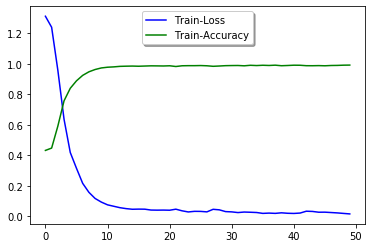

In [28]:
plt.plot(list(results.history.values())[0],'b',label='Train-Loss')
plt.plot(list(results.history.values())[1],'g',label='Train-Accuracy')
plt.legend(loc='upper center', shadow=True)

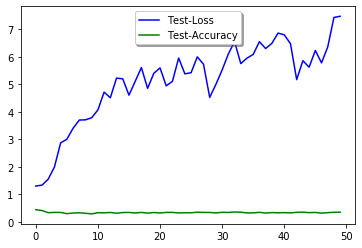

In [29]:
plt.plot(list(results.history.values())[2],'b',label='Test-Loss')
plt.plot(list(results.history.values())[3],'g',label='Test-Accuracy')
plt.legend(loc='upper center', shadow=True)

## Image Data + CNN

In [33]:
# Train-test Split
np.random.RandomState(0)
trainX, testX, trainY, testY = train_test_split(X, Y, test_size=0.2, random_state=0,stratify=Y)

# summarize dataset shape
print('Train', trainX.shape, trainY.shape)
print('Test', (testX.shape, testY.shape))

# summarize pixel values
print('Train', trainX.min(), trainX.max(), trainX.mean(), trainX.std())
print('Test', testX.min(), testX.max(), testX.mean(), testX.std())

Train (5259, 50, 73, 3) (5259, 5)
Test ((1315, 50, 73, 3), (1315, 5))
Train 0 255 123.00404316670443 89.75326426829038
Test 0 255 123.13026442349428 89.86279273103294


In [0]:
# reshape dataset to have a single channel
# width, height, channels = trainX.shape[1], trainX.shape[2], trainX.shape[3]
# trainX = trainX.reshape((trainX.shape[0], width,height,channels))
# testX = testX.reshape((testX.shape[0], width,height,channels))

# one hot encode target values
# trainY = to_categorical(trainY.factorize()[0])
# testY = to_categorical(testY.factorize()[0])

# create generator (1.0/255.0 = 0.003921568627451)
# datagen = ImageDataGenerator(featurewise_center=True, featurewise_std_normalization=True) # standardize

# prepare an iterators to scale images
# train_iterator = datagen.flow(trainX, trainY, batch_size=64)
# test_iterator = datagen.flow(testX, testY, batch_size=64)
# print('Batches train=%d, test=%d' % (len(train_iterator), len(test_iterator)))

# confirm the scaling works
# batchX, batchy = train_iterator.next()
# print('Batch shape=%s, min=%.3f, max=%.3f' % (batchX.shape, batchX.min(), batchX.max()))

In [34]:
# define model
model = Sequential()
model.add(Conv2D(64, (3, 3), activation='relu', input_shape=(width, height, channels)))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.2))


model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(64, activation='relu'))


model.add(Dense(5, activation='softmax'))

# compile model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 48, 71, 64)        1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 24, 35, 64)        0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 24, 35, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 22, 33, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 11, 16, 64)        0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 11, 16, 64)        0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 11264)            

In [35]:
# fit model with generator
results = model.fit(trainX, trainY,
         epochs=50,
         batch_size=64,
         shuffle=True,
#         validation_split=0.2
         validation_data=(testX,testY)
         )
# model.fit_generator(train_iterator, steps_per_epoch=len(train_iterator), epochs=1)

# evaluate model
# _, acc = model.evaluate_generator(test_iterator, steps=len(test_iterator), verbose=0)
# print('Test Accuracy: %.3f' % (acc * 100))

Train on 5259 samples, validate on 1315 samples
Epoch 1/50
5259/5259 [==============================] - 2s 378us/sample - loss: 13.2029 - acc: 0.3750 - val_loss: 1.5413 - val_acc: 0.4198
Epoch 2/50
5259/5259 [==============================] - 1s 224us/sample - loss: 1.3937 - acc: 0.4107 - val_loss: 1.4989 - val_acc: 0.4259
Epoch 3/50
5259/5259 [==============================] - 1s 223us/sample - loss: 1.3683 - acc: 0.4103 - val_loss: 1.4667 - val_acc: 0.4350
Epoch 4/50
5259/5259 [==============================] - 1s 224us/sample - loss: 1.3468 - acc: 0.4231 - val_loss: 1.4209 - val_acc: 0.4304
Epoch 5/50
5259/5259 [==============================] - 1s 226us/sample - loss: 1.3311 - acc: 0.4408 - val_loss: 1.3864 - val_acc: 0.4342
Epoch 6/50
5259/5259 [==============================] - 1s 222us/sample - loss: 1.3028 - acc: 0.4478 - val_loss: 1.3616 - val_acc: 0.4342
Epoch 7/50
5259/5259 [==============================] - 1s 224us/sample - loss: 1.2607 - acc: 0.4628 - val_loss: 1.3609 - v

In [36]:
model.evaluate(testX,testY)

1315/1315 [==============================] - 0s 226us/sample - loss: 4.1458 - acc: 0.3681


[4.145778516943464, 0.36806083]

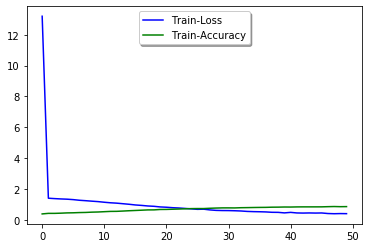

In [37]:
plt.plot(list(results.history.values())[0],'b',label='Train-Loss')
plt.plot(list(results.history.values())[1],'g',label='Train-Accuracy')
plt.legend(loc='upper center', shadow=True)

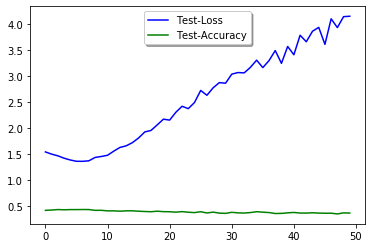

In [38]:
plt.plot(list(results.history.values())[2],'b',label='Test-Loss')
plt.plot(list(results.history.values())[3],'g',label='Test-Accuracy')
plt.legend(loc='upper center', shadow=True)

# Manual Test

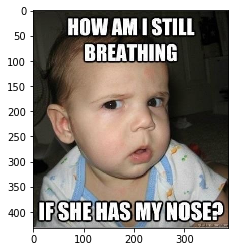

In [0]:
test_img = cv2.cvtColor(cv2.imread(PATH_IMG+data['Image_name'][1]), cv2.COLOR_BGR2RGB)
plt.imshow(test_img)

In [0]:
data[:5]

,Image_name,OCR_extracted_text,Overall_Sentiment
0,10_year_10-year-challenge_1547788782.jpeg,The best of #10 YearChallenge! Completed in le...,very_positive
1,10_year_10yearchallenge-5c75f8b946e0fb0001edc7...,Sam Thorne @Strippin ( Follow Follow Saw every...,positive
2,10_year_10-year-challenge-sweet-dee-edition-40...,10 Year Challenge - Sweet Dee Edition,positive
3,10_year_10-year-challenge-with-no-filter-47-hi...,10 YEAR CHALLENGE WITH NO FILTER 47 Hilarious ...,neutral
4,10_year_10-years-challenge-about-humanity_o_72...,"1998: ""Don't get in car with strangers"" 2008: ...",negative


In [0]:
#prediction
temp = model.predict(X[800:813].reshape(-1,50,73,3))
temp_pre = [np.argmax(i) for i in temp]
temp_pre

[3, 2, 1, 1, 2, 1, 2, 2, 3, 2, 0, 1, 2]

In [0]:
#Ground Truth
temp = Y[800:813]
temp_truth = [np.argmax(i) for i in temp]
temp_truth

[2, 0, 2, 4, 2, 1, 0, 1, 3, 4, 0, 1, 1]

In [0]:
accuracy_score(temp_pre, temp_truth)

0.38461538461538464

In [0]:
model.evaluate(X[800:813],Y[800:813])

13/13 [==============================] - 0s 573us/sample - loss: 1.4527 - acc: 0.7538


[1.4527454376220703, 0.75384617]

In [0]:
12/13

0.9230769230769231